源代码基于：https://blog.csdn.net/xufive/article/details/104093197

In [1]:
# -*- coding: utf-8 -*-
# Disable warnings 
import warnings
warnings.filterwarnings('ignore')
import time
import json
import requests
import urllib
from datetime import datetime
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.figure
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
"""抓取每日确诊和死亡数据"""
seconds = time.time()
print("Seconds since epoch =", seconds)
local_time = time.ctime(seconds)
print("Local time:", local_time)

url = 'https://view.inews.qq.com/g2/getOnsInfo?name=wuwei_ww_cn_day_counts&callback=&_=%d'%int(seconds*1000)
# e.g. 'https://view.inews.qq.com/g2/getOnsInfo?name=wuwei_ww_cn_day_counts&callback=&_=1581902171562'
json_data = json.loads(requests.get(url=url).json()['data'])
json_data.sort(key=lambda x:x['date'])

Seconds since epoch = 1582086032.48284
Local time: Wed Feb 19 13:20:32 2020


In [3]:
import pandas as pd
data0 = pd.DataFrame.from_dict(json_data)  # convert to dataframe
data = data0[['confirm', 'suspect', 'dead', 'heal', 'now_severe', 'now_confrim']].fillna(0).astype('int') 
data['date'] = data0['date'].apply(lambda x: datetime(2020, int(x.split("/")[0]), int(x.split("/")[1])))
data = data[['date','confirm', 'suspect', 'dead', 'heal', 'now_severe', 'now_confrim']] 
data.tail()

,date,confirm,suspect,dead,heal,now_severe,now_confrim
32,2020-02-14,66576,8969,1524,8101,11053,56951
33,2020-02-15,68584,8228,1666,9425,11272,57492
34,2020-02-16,70635,7264,1772,10853,10644,58010
35,2020-02-17,72528,6242,1870,12561,11741,58097
36,2020-02-18,74279,5248,2006,14387,11977,57886


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 7 columns):
date           37 non-null datetime64[ns]
confirm        37 non-null int64
suspect        37 non-null int64
dead           37 non-null int64
heal           37 non-null int64
now_severe     37 non-null int64
now_confrim    37 non-null int64
dtypes: datetime64[ns](1), int64(6)
memory usage: 2.1 KB


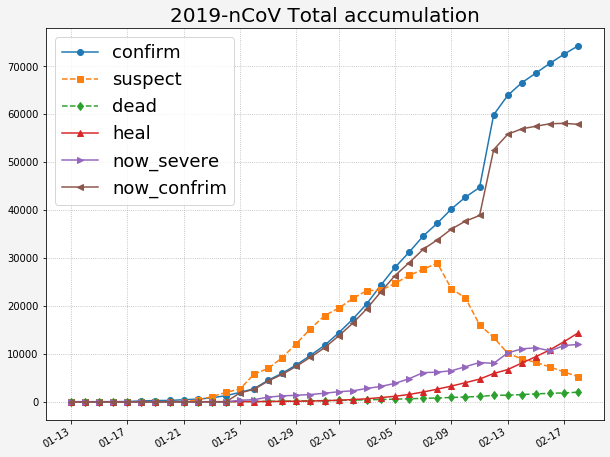

In [5]:
plt.figure('2019-nCoV Total accumulation', facecolor='#f4f4f4', figsize=(10, 8))
plt.title('2019-nCoV Total accumulation', fontsize=20)

plt.plot(data.date, data.confirm,'o-', label='confirm')
plt.plot(data.date, data.suspect,'s--', label='suspect')
plt.plot(data.date, data.dead,'d--', label='dead')
plt.plot(data.date, data.heal,'^-',label='heal')
plt.plot(data.date, data.now_severe,'>-',label='now_severe')
plt.plot(data.date, data.now_confrim,'<-',label='now_confrim')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) # 格式化时间轴标注
plt.gcf().autofmt_xdate() # 优化标注（自动倾斜）
plt.grid(linestyle=':') # 显示网格
plt.legend(loc='best',fontsize=18) # 显示图例
#plt.savefig('2019-nCoV疫情曲线.png') # 保存为文件
plt.show()

In [6]:
data['new_confirm'] = data.confirm.diff()
data['new_suspect'] = data.suspect.diff()
data['new_dead']    = data.dead.diff()
data['new_heal']    = data.heal.diff()
data['new_severe']    = data.now_severe.diff()


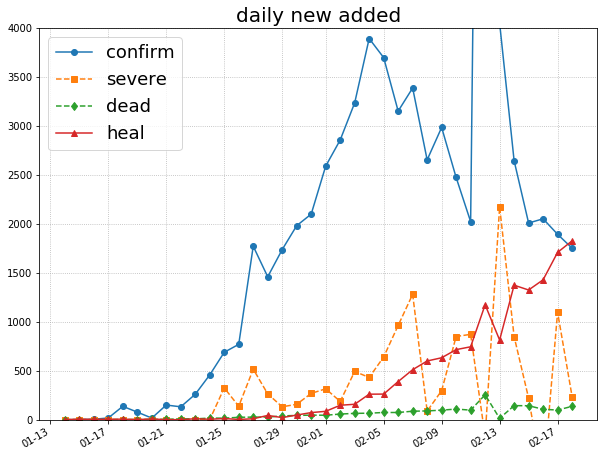

In [7]:
plt.figure( figsize=(10, 8))
plt.title('daily new added', fontsize=20)

plt.plot(data.date, data.new_confirm,'o-', label='confirm')
plt.plot(data.date, data.new_severe,'s--', label='severe')
plt.plot(data.date, data.new_dead,'d--', label='dead')
plt.plot(data.date, data.new_heal,'^-',label='heal')
plt.ylim([0,4000])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) # 格式化时间轴标注
plt.gcf().autofmt_xdate() # 优化标注（自动倾斜）
plt.grid(linestyle=':') # 显示网格
plt.legend(loc='best',fontsize=18) # 显示图例
#plt.savefig('2019-nCoV疫情曲线.png') # 保存为文件
plt.show()

# 致死率估算

In [8]:
data['dead_rate_upper']    = data.new_dead/(data.new_heal+data.new_dead)
data['dead_rate_lower']    = data.dead/(data.confirm)

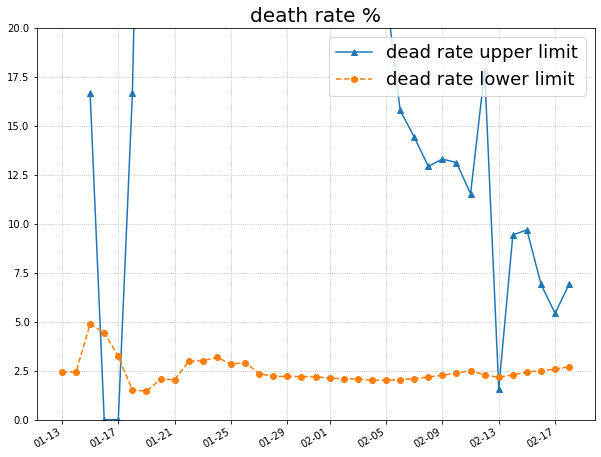

In [9]:
plt.figure(figsize=(10, 8))
plt.title('death rate %', fontsize=20)
plt.plot(data.date, data.dead_rate_upper*100,'^-',label='dead rate upper limit')
plt.plot(data.date, data.dead_rate_lower*100,'o--',label='dead rate lower limit')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) # 格式化时间轴标注
plt.gcf().autofmt_xdate() # 优化标注（自动倾斜）
plt.grid(linestyle=':') # 显示网格
plt.legend(loc='upper right',fontsize=18) # 显示图例
plt.ylim([0,20])
plt.show()

上图的评论：**致死率上限的算法的缺陷在于，确诊的人，康复的往往比死亡的需要更多时间，也就是拖尾很长。用当天死亡除以（死亡+康复）会漏掉大部分还处于轻症和重症的数据。**

## 用平均死亡时间估算

In [10]:
def estimate_death_rate(data, delay = 7):
    rate = np.zeros(shape = (data.shape[0],))
    data['new_confirm']=data['new_confirm'].fillna(0)
    for i in data.index:
        if i - delay <0:
            continue
        if data.loc[i - delay,'new_confirm'] > 0:
            rate[i] = data.loc[i,'new_dead']/data.loc[i - delay,'new_confirm']
    return rate

In [11]:
data['delay15'] = estimate_death_rate(data, delay = 15)
data['delay20'] = estimate_death_rate(data, delay = 20)
data['delay10'] = estimate_death_rate(data, delay = 10)

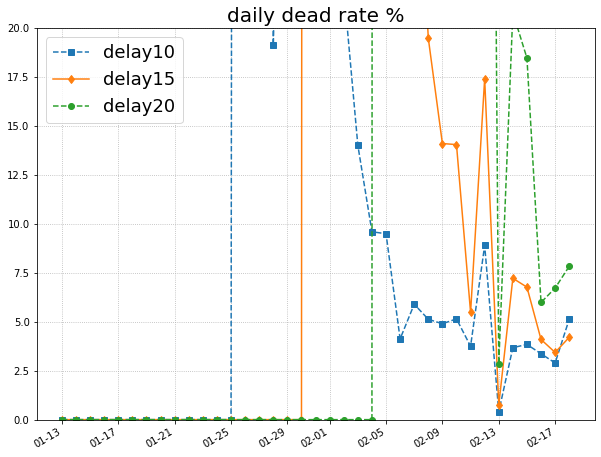

In [12]:
plt.figure( figsize=(10, 8))
plt.title('daily dead rate %', fontsize=20)


plt.plot(data.date, data['delay10']*100,'s--', label='delay10')
plt.plot(data.date, data['delay15']*100,'d-', label='delay15')
plt.plot(data.date, data['delay20']*100,'o--',label='delay20')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) # 格式化时间轴标注
plt.gcf().autofmt_xdate() # 优化标注（自动倾斜）
plt.grid(linestyle=':') # 显示网格
plt.legend(loc='best',fontsize=18) # 显示图例
#plt.savefig('2019-nCoV疫情曲线.png') # 保存为文件
plt.ylim([0,20])
plt.show()

**结论**：
1. 前期确诊病例偏低，确诊的都是晚期，导致致死率偏高，即远远高于20%
2. 假设确诊后平均死亡时间是10到20天，则死亡率在 3%-6%。 
3. 如果能得到及时救治，死亡率将进一步下降。
4. 更准确的死亡率估计需要分区域，如武汉市，武汉以外的湖北省，湖北省以外的中国，国外，钻石公主号等等
5. 还需要区分年龄段和性别，有无慢性病等等。


https://mama.dxy.com/outbreak/daily-of-nationwide-new?index=20200216&locationIds=999&from=Previous_Review
- 治愈率: 40% 
-  出院时间: 平均15天，重症19天

# 最后结论
由下表可以看出：
1. 各种模型对死亡率的估计为 0.05， 0.026， 0.03，0.067，0.03，所以预计最终的死亡率是3%左右
2. 存量确诊高达5万8千，存量重症高达1万1千多。这说明两个问题：对救护资源的需求是非常大的，康复的周期也是比死亡要长得多
3. 每日新增确诊和每日治愈的数目大致相当。 说明疫情基本趋于稳定。现在的问题是如何消化大量库存，以及库存的消化时间。
4. 复工潮带来的交叉感染问题，那么每日新增就不会迅速降低，至少要持续半个月，再加上半个月的治疗期，那么疫情最乐观的估计也是三月底消退，完全消除大概就是四月底了。

In [13]:
data.tail()

,date,confirm,suspect,dead,heal,now_severe,now_confrim,new_confirm,new_suspect,new_dead,new_heal,new_severe,dead_rate_upper,dead_rate_lower,delay15,delay20,delay10
32,2020-02-14,66576,8969,1524,8101,11053,56951,2644.0,-1140.0,143.0,1373.0,849.0,0.094327,0.022891,0.072186,0.207849,0.036742
33,2020-02-15,68584,8228,1666,9425,11272,57492,2008.0,-741.0,142.0,1324.0,219.0,0.096862,0.024291,0.067651,0.184655,0.038410
34,2020-02-16,70635,7264,1772,10853,10644,58010,2051.0,-964.0,106.0,1428.0,-628.0,0.069100,0.025087,0.040942,0.059853,0.033640
35,2020-02-17,72528,6242,1870,12561,11741,58097,1893.0,-1022.0,98.0,1708.0,1097.0,0.054264,0.025783,0.034314,0.067169,0.028934
36,2020-02-18,74279,5248,2006,14387,11977,57886,1751.0,-994.0,136.0,1826.0,236.0,0.069317,0.027006,0.042040,0.078296,0.051263
